In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random

import cv2
from scipy import stats
import os
%matplotlib inline

In [2]:
# #fix all seeds for random number generators
# # Set seed value
# seed_value = 9
# import os
# os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
# random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
# np.random.seed(seed_value)
# tf.random.set_seed(seed_value)# 5. Configure a new global `tensorflow` session

# #TODO need to initiate session here on tensorflow to fix random seeds
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #use only cpu

import tensorflow as tf

In [3]:
#Params

mdlname = 'saved_model/cnn3v27'
mdl_paramsfn = 'depthforcemodelparam_cnn3v27_pb.pkl'
# datapath = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo"
datapath = r'C:\Users\Alex\Box Sync\CS598 - Final Project\Preliminary Data V5\Test_Subject_Leo'

In [4]:
# def create_model():
    
#     from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, concatenate, AveragePooling2D
#     from tensorflow.keras.layers import BatchNormalization
#     from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute, Flatten
#     from tensorflow.keras.models import Model
#     dropout_rate = 0.2

#     model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
#     model_start2 = Input(shape=(xfcss_train.shape[1],))
#     model_cnn = model_start
#     model_perc = model_start2

#     model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same')(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

#     model_perc = Dense(100)(model_perc)
#     model_perc = Activation('relu')(model_perc)

#     model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same')(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

#     model_perc = Dense(100)(model_perc)
#     model_perc = Activation('relu')(model_perc)

#     model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same')(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

#     model_cnn = Conv2D(filters=96, kernel_size=(3, 3),padding='same')(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

#     model_cnn = Flatten()(model_cnn)


#     model_cnn = Dense(128)(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
# #     model_cnn = Dropout(dropout_rate)(model_cnn)

#     model_comb = concatenate([model_cnn,model_perc],axis=-1)

#     model_comb = Dense(100)(model_comb)
#     model_comb = Activation('relu')(model_comb)
#     model_comb = Dropout(dropout_rate)(model_comb)

#     output = Dense(1)(model_comb)
#     output = Activation('linear', name='thetaz_out')(output)
#     model = Model(inputs=[model_start,model_start2],outputs=output)
    
#     return model
    
    

In [5]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#             gray_frame = frame/np.maximum(np.max(frame),255) keep as int8 for memory savings
            gray_frame = frame
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [6]:
n_test = (47,49)
nw_resize = 2
nh_resize = 2
xtemp = {}
show_video = 0
subj = ['leo','leo']
        
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5 Incline','Test_Subject_'+subj[i],test_str)
#     train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    train_dcamera_path = os.path.join(data_dir , 'depth_processed_'+subj[i]+'_test'+str(n_test[i])+'.avi')
    xtemp[i] = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize).astype('uint8')

tlen=0
for x in range(len(xtemp)):
    tlen+= xtemp[x].shape[0]
xrun_cum = 0
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]),dtype='uint8')
for i in range (len(xtemp)):
    xrun_n = len(xtemp[i])
    x_train[xrun_cum:xrun_cum+xrun_n,:,:,:] = xtemp[i][:xrun_n,:,:,:]
    xrun_cum += xrun_n
    
del xtemp

## Read Input Data: FCSS
n_test = (47,49)
date = ('12_15_2020','12_15_2020')
subj = ['leo','leo']
subjwgt = [67, 67]
subjht = [174, 174]
xfcss_gt = {}
yrun = 0
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5 Incline','Test_Subject_'+subj[i],test_str)
    fcss_data_dir = os.path.join(data_dir , 'fcss_processed_'+subj[i]+'_' + test_str + '_' + date[i] + '.txt')
    xfcss_gttemp = pd.read_csv(fcss_data_dir)/subjwgt[i]*subjht[i]**2
    xfcss_gt[i]=xfcss_gttemp
#     xfcss_gt[i]['weight'] = subjwgt[i]# hacky but will work for now
#     xfcss_gt[i]['height'] = subjht[i]# hacky but will work for now
    if i==0:
        xfcss_train=xfcss_gttemp
    else:
        xfcss_train = pd.concat([xfcss_train,xfcss_gt[i]],axis=0)
del xfcss_gt

In [7]:
# # Read in Input Data 
# #TODO clean up this section of code for easy access from other computers
# n_test = (1,2,24,30,31,32,33,35,1,3)
# nw_resize = 2
# nh_resize = 2
# xtemp = {}
# show_video = 0
# subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
        
# for i in range(len(n_test)):
#     test_str = 'test' + str(n_test[i])
    
# #     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
#     data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
# #     train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
#     train_dcamera_path = os.path.join(data_dir , 'depth_processed_'+subj[i]+'_test'+str(n_test[i])+'.avi')
#     xtemp[i] = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize).astype('uint8')

# tlen=0
# for x in range(len(xtemp)):
#     tlen+= xtemp[x].shape[0]
# xrun_cum = 0
# x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]),dtype='uint8')
# for i in range (len(xtemp)):
#     xrun_n = len(xtemp[i])
#     x_train[xrun_cum:xrun_cum+xrun_n,:,:,:] = xtemp[i][:xrun_n,:,:,:]
#     xrun_cum += xrun_n
    
# del xtemp

# ## Read Input Data: FCSS
# n_test = (1,2,24,30,31,32,33,35,1,3)
# date = ('12_2_2020','12_11_2020','11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020','12_2_2020','12_11_2020')
# subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
# subjwgt = [61,61, 67, 67, 67, 67, 67, 67, 70, 70]
# subjht = [180, 180, 174, 174, 174, 174, 174, 174, 170, 170]
# xfcss_gt = {}
# yrun = 0
# for i in range(len(n_test)):
#     test_str = 'test' + str(n_test[i])
# #     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
#     data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
#     fcss_data_dir = os.path.join(data_dir , 'fcss_processed_'+subj[i]+'_' + test_str + '_' + date[i] + '.txt')
#     xfcss_gttemp = pd.read_csv(fcss_data_dir)/subjwgt[i]*subjht[i]**2
#     xfcss_gt[i]=xfcss_gttemp
# #     xfcss_gt[i]['weight'] = subjwgt[i]# hacky but will work for now
# #     xfcss_gt[i]['height'] = subjht[i]# hacky but will work for now
#     if i==0:
#         xfcss_train=xfcss_gttemp
#     else:
#         xfcss_train = pd.concat([xfcss_train,xfcss_gt[i]],axis=0)
# del xfcss_gt

In [8]:
train_dcamera_path

'C:\\Users\\Alex\\Box\\CS598 - Final Project\\Preliminary Data V5 Incline\\Test_Subject_leo\\test49\\depth_processed_leo_test49.avi'

In [9]:
# Read in Output Data 
#TODO clean up this section of code for easy access from other computers
n_test = (47,49)
date = ('12_15_2020','12_15_2020')
subj = ['leo','leo']
y_gt = {}
yrun = 0
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5 Incline','Test_Subject_'+subj[i],test_str)
    qtm_file_data_dir = os.path.join(data_dir , 'qtm_processed_'+subj[i]+'_test' + str(n_test[i]) + '_' + date[i] + '.txt')
    y_gt[i] = read_output_data(qtm_file_data_dir,theta_interest).values
    
tlen=0
for x in range(len(y_gt)):
    tlen+= y_gt[x].shape[0]
yrun_cum = 0
y_train = np.zeros((tlen,1))
for i in range (len(y_gt)):
    yrun_n = len(y_gt[i])
    y_train[yrun_cum:yrun_cum+yrun_n] = y_gt[i][:]
    yrun_cum += yrun_n
del y_gt

In [10]:
# # Read in Output Data 
# #TODO clean up this section of code for easy access from other computers
# n_test = (1,2,24,30,31,32,33,35,1,3)
# date = ('12_2_2020','12_11_2020','11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020','12_2_2020','12_11_2020')
# subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
# y_gt = {}
# yrun = 0
# theta_interest = 'z'
# for i in range(len(n_test)):
#     test_str = 'test' + str(n_test[i])
# #     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
#     data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
#     qtm_file_data_dir = os.path.join(data_dir , 'qtm_processed_'+subj[i]+'_test' + str(n_test[i]) + '_' + date[i] + '.txt')
#     y_gt[i] = read_output_data(qtm_file_data_dir,theta_interest).values
    
# tlen=0
# for x in range(len(y_gt)):
#     tlen+= y_gt[x].shape[0]
# yrun_cum = 0
# y_train = np.zeros((tlen,1))
# for i in range (len(y_gt)):
#     yrun_n = len(y_gt[i])
#     y_train[yrun_cum:yrun_cum+yrun_n] = y_gt[i][:]
#     yrun_cum += yrun_n
# del y_gt

In [11]:
## Saturate output
# def saturate(theta, min_val, max_val):
#     for i in range(len(theta)):
#         if theta[i] < min_val:
#             theta[i] = min_val
#             continue
#         if theta[i] > max_val:
#             theta[i] = max_val
#             continue
#     return theta
            
# min_val = -50
# max_val = 50
    
# y_train = saturate(y_train, min_val, max_val)

In [12]:
load_prevset = 1# (1): load previously trained Nnet Regression Model (0): Create new Nnet Regression Model to train
ranold = 0

if load_prevset:
    
    with open(mdl_paramsfn, 'rb') as file:
        mdl_prm = pickle.load(file)
    
    randata=mdl_prm[0]
    sc_y=mdl_prm[1]
    sc_X2 = mdl_prm[2]
#     modelhistory=mdl_prm[3]
    if ranold:
        nsamps = randata['nsamps']
        n80p = randata['n80p']
        rannums = randata['rannums']
        test_set = randata['test_set']
    else:
        nsamps = x_train.shape[0]
        n80p = int(np.floor(nsamps*0.8))
        rannums = np.array(random.sample(range(1,nsamps,1), n80p))
        s_nfiles = np.arange(nsamps)
        test_set = np.setdiff1d(s_nfiles,rannums)
else:
    
    sc_y = StandardScaler()
    sc_X2 = StandardScaler()

In [13]:
# dont randomize
Testset = x_train
Testset2 = xfcss_train.values
Testy = y_train

In [14]:
# Trainset = x_train[rannums,:]
# Trainset2 = xfcss_train.values[rannums,:]
# Testset = x_train[test_set,:]
# Testset2 = xfcss_train.values[test_set,:]
# # Trainy= y_gt[rannums,:]
# # Testy = y_gt[test_set,:]
# Trainy= y_train[rannums,:]
# Testy = y_train[test_set,:]
# Xtrainz = Trainset
# Xtrainz2 = Trainset2
# ytrainz = Trainy
# X = Xtrainz
# X2 = sc_X2.fit_transform(Xtrainz2)
# y = sc_y.fit_transform(ytrainz)
# Xvalid = Testset
# Xvalid2 = sc_X2.transform(Testset2)
# y_valid = Testy
# y_valid = sc_y.transform(y_valid)

In [15]:
def load_mdl(mdlname):
#     model=create_model()
#     modelname = mdlname
#     model.load_weights(modelname)
    model = tf.keras.models.load_model(mdlname)
    return model

In [16]:
model = load_mdl(mdlname)

In [17]:
# import keras
# import pydot
# import pydotplus
# from keras.utils.vis_utils import model_to_dot
# keras.utils.vis_utils.pydot = pydot
# keras.utils.plot_model(model, to_file='model.png')

In [18]:
# tf.keras.utils.plot_model(model, to_file='model.png',rankdir='TB',show_shapes=False,expand_nested=True)

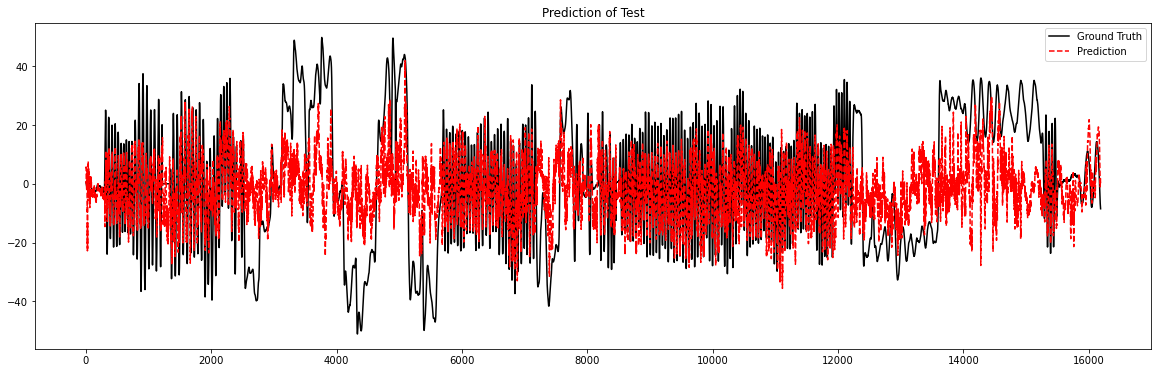

Average error is -2.15 degrees
Root Mean Squared Error is 14.40 degrees
Mean Absolute Error is 14.40 degrees


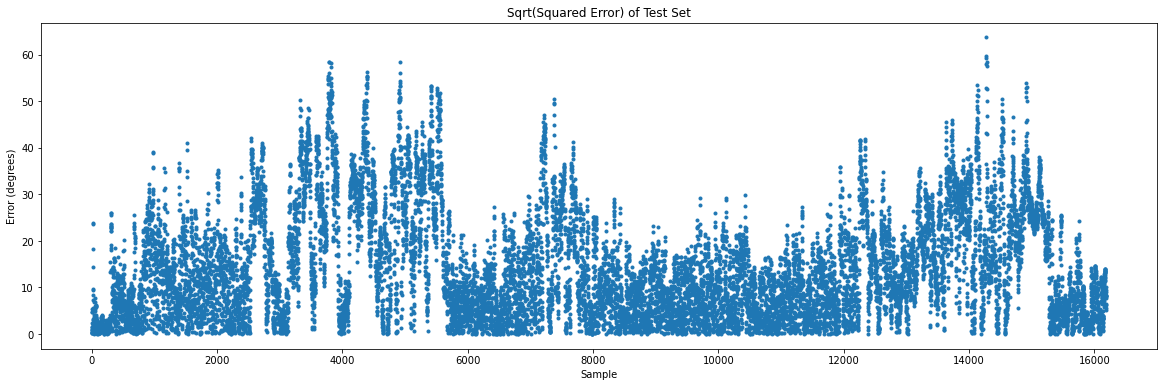

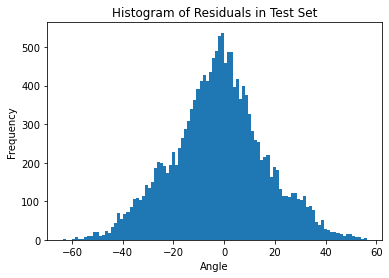

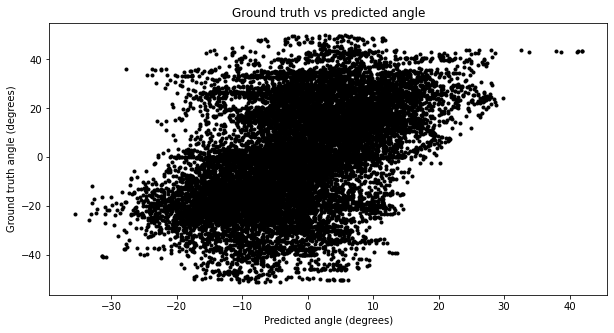

In [19]:
#Test
Xtest = Testset/255.
Xtest2 = sc_X2.transform(Testset2)
y_pred = model.predict([Xtest,Xtest2])

y_pred = sc_y.inverse_transform(y_pred)
# y_pred_sat = saturate(y_pred, min_val, max_val)
y_new = Testy



plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [16]:
loss, mse_std, mae_std = model.evaluate([Xtest,Xtest2], sc_y.transform(Testy), verbose=2)
mae = mae_std*sc_y.var_[0]**0.5
print('Restored model, accuracy: {:5.2f} degrees'.format(mae))

506/506 - 13s - loss: 1.1993 - mean_squared_error: 2.3384 - mean_absolute_error: 1.1993
Restored model, accuracy: 14.05 degrees


In [ ]:
%matplotlib qt

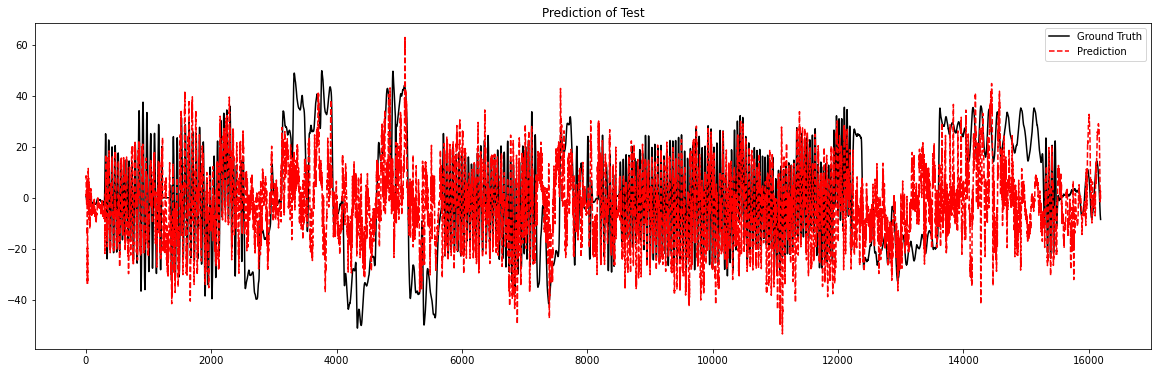

In [21]:
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred*1.5,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error
